## Hodgkin-Huxley model with one channel in response to several voltage-clamps protocols
### Channel identity. ICG id: 1708, ModelDB id: 2488

In [18]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import time

from matplotlib import pyplot as plt

## Voltage-clamp protocol

In [19]:
prot = ['v_act','v_inact','v_deact','v_ap','v_ramp']
p = 0
protocols = \
pd.read_csv('~/repos/lfi-models/lfimodels/channelomics/protocols/na_channels/'+prot[p]+'.dat',sep='\t')
protocols = protocols.drop(protocols.columns[-1],axis=1)

# extract voltages and time
protocols1 = protocols.values

V = protocols1[:,1:].T
t = protocols1[:,0]   # attention: time step varies, but we will assume that it is constant
tstep = np.mean(np.diff(t)) # ms

FileNotFoundError: File b'/home/pedro/Documents/repos/lfi-models/lfimodels/channelomics/protocols/na_channels/v_act.dat' does not exist

## Parameters and kinetics

In [4]:
# parameters
celsius = 37    # original temperature
temp = 23       # reference temperature
q10 = 2.3       # temperature sensitivity
tadj = q10**((celsius - temp)/10)

g_L = 3.334e-2 # mS/cm2
E_L = -80 # not sure which one is used in Podlaski et al. 2017, mV

gbar_Na = 1.0 # mS/cm2
E_Na = 50 # mV

noise_std = 0.0001

###############################################################################
# kinetics
def efun(z):
    ind = np.abs(z) < 1e-6
    efun1 = z*1.
    efun1[ind] = 1 - z[ind]/2
    efun1[~ind] = z[~ind] / (np.exp(z[~ind]) - 1)
    return efun1

def alpha_m(x):
    v1 = x + 35
    return 0.182 * 9 * efun(-v1/9)

def beta_m(x):
    v1 = x + 35
    return 0.124 * 9 * efun(v1/9)

def alpha_h(x):
    v1 = x + 50
    return 0.024 * 5 * efun(-v1/5)

def beta_h(x):
    v1 = x + 75
    return 0.0091 * 5 * efun(v1/5)


def tau_m(x):
    return 1/(alpha_m(x) + beta_m(x))
def m_inf(x):
    return alpha_m(x)/(alpha_m(x) + beta_m(x))
def tau_h(x):
    return 1/(alpha_h(x) + beta_h(x))
def h_inf(x):
    v1 = x + 65
    return 1/(1+np.exp(v1/6.2))

## Voltage-clamp simulation

In [5]:
t_sim = time.time()

m = np.zeros_like(V)
h = np.zeros_like(V)

m[:,0] = m_inf(V[:,0])
h[:,0] = h_inf(V[:,0])

for i in range(1, t.shape[0]):
    m_inf1 = m_inf(V[:,i-1])+noise_std*np.random.randn()/(tstep**0.5)
    h_inf1 = h_inf(V[:,i-1])+noise_std*np.random.randn()/(tstep**0.5)
    m[:,i] = m_inf1+(m[:,i-1]-m_inf1)*np.exp(-tstep*tadj/tau_m(V[:,i-1]))
    h[:,i] = h_inf1+(h[:,i-1]-h_inf1)*np.exp(-tstep*tadj/tau_h(V[:,i-1]))
    
print(time.time() - t_sim)


fact_inward = -1 # inward current pre-multiplied by -1 (see page 15 of Podlasky et al. 2017)

I_Na = fact_inward*tadj*gbar_Na*(m**3)*h*(V-E_Na)
I_Na = I_Na/np.max(I_Na)
# I_L = tadj*g_L*(V-E_L)
# I_tot = (I_Na + I_L)/np.max(I_Na + I_L)

0.7980220317840576


## Plot

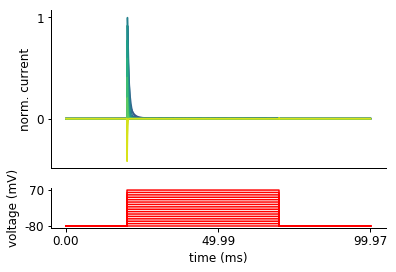

In [6]:
# %matplotlib notebook
num_levels = len(V[:,0])
cm1 = mpl.cm.viridis
col1 = [cm1(1.*i/num_levels) for i in range(num_levels)]

# scal_y = 1

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_levels):
    plt.plot(t,I_Na[i,], color = col1[i])
plt.ylabel('norm. current')
ax.set_xticks([])
ax.set_yticks([0, 1.001*np.max(I_Na)])
# ax.set_ylim([0,scal_y])

ax = plt.subplot(gs[1])
for i in range(num_levels):
    plt.plot(t, V[i,],'r')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

duration = np.max(t)
ax.set_xticks([0, duration/2, duration])
ax.set_yticks([np.min(V), np.max(V)])

plt.show()

## Checking model implementation against it (attention: discrepancy in temporal resolution)

In [1]:
from lfimodels.channelomics.Channel import Channel
m = Channel(channel_type='na')

import numpy as np
out = m.gen_single(np.array([-35, 9, 0.182, 0.124, -50, -75, 5, -65, 6.2, 0.0091, 0.024]))

import matplotlib.pyplot as plt
%matplotlib inline

N2 = out['v_act']['data']
t2 = out['v_act']['time']

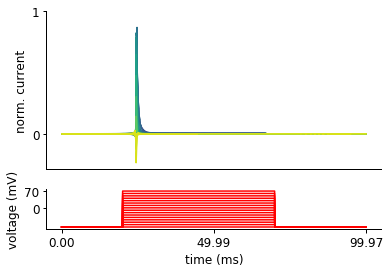

In [7]:
num_levels = len(V[:,0])
cm1 = mpl.cm.viridis
col1 = [cm1(1.*i/num_levels) for i in range(num_levels)]

gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[4, 1])
ax = plt.subplot(gs[0])
for i in range(num_levels):
    plt.plot(t2, N2[i,], color = col1[i])
plt.ylabel('norm. current')
ax.set_xticks([])
ax.set_yticks([0, 1.001*np.max(I_Na)])

ax = plt.subplot(gs[1])
for i in range(num_levels):
    plt.plot(t, V[i,],'r')
plt.xlabel('time (ms)')
plt.ylabel('voltage (mV)')

duration = np.max(t)
ax.set_xticks([0, duration/2, duration])
ax.set_yticks([0, np.max(V)])

plt.show()